# Importing frameworks

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, r2_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import  SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint



# Importing a datasets

In [2]:
#data for training the model
train = pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv', encoding='ISO-8859–1')

#data for testing 
test = pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Test.csv', encoding='ISO-8859–1')

# Data description

## Input variables:
**vID** - Unique ID (can not be used for predictions)

**Gender** - Sex

**City** - Current City

**Monthly_Income** - Monthly Income in rupees

**DOB** - Date of Birth

**Lead_Creation_Date** - Lead Created on date

**Loan_Amount_Applied** - Loan Amount Requested (INR)

**Loan_Tenure_Applied** - Loan Tenure Requested (in years)

**Existing_EMI** - EMI of Existing Loans (INR)

**Employer_Name** - Employer Name

**Salary_Account** - Salary account with Bank

**Mobile_Verified** - Mobile Verified (Y/N)

**Var5** - Continuous classified variable

**Var1** - Categorical variable with multiple levels

**Loan_Amount_Submitted** - Loan Amount Revised and Selected after seeing Eligibility

**Loan_Tenure_Submitted** - Loan Tenure Revised and Selected after seeing Eligibility (Years)

**Interest_Rate** - Interest Rate of Submitted Loan Amount

**Processing_Fee** - Processing Fee of Submitted Loan Amount (INR)

**EMI_Loan_Submitted** - EMI of Submitted Loan Amount (INR)

**Filled_Form** - Filled Application form post quote

**Device_Type** - Device from which application was made (Browser/ Mobile)

**Var2** - Categorical Variable with multiple Levels

**Source** - Categorical Variable with multiple Levels

**Var4** - Categorical Variable with multiple Levels

## Outcomes:

**LoggedIn**- Application Logged (Variable for understanding the problem – cannot be used in prediction)

**Disbursed**- Loan Disbursed (Target Variable)

# Target
## **Identify the customers segments having higher conversion ratio for a specific loan product** 

In [3]:
df = train.copy()[:1000]

In [4]:
df.shape

(1000, 26)

In [5]:
df.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     1000 non-null   object 
 1   Gender                 1000 non-null   object 
 2   City                   1000 non-null   object 
 3   Monthly_Income         1000 non-null   int64  
 4   DOB                    1000 non-null   object 
 5   Lead_Creation_Date     1000 non-null   object 
 6   Loan_Amount_Applied    1000 non-null   float64
 7   Loan_Tenure_Applied    1000 non-null   float64
 8   Existing_EMI           1000 non-null   float64
 9   Employer_Name          1000 non-null   object 
 10  Salary_Account         934 non-null    object 
 11  Mobile_Verified        1000 non-null   object 
 12  Var5                   1000 non-null   int64  
 13  Var1                   1000 non-null   object 
 14  Loan_Amount_Submitted  669 non-null    float64
 15  Loan_

## Target variable distribution

In [7]:
print(df['Disbursed'].value_counts(normalize=True))

0    0.989
1    0.011
Name: Disbursed, dtype: float64


Dataset shows a large class imbalance. Only 1.4% of the study population had disbursed loans.

# Feature transformation  and selection

In [8]:
to_remove = ['ID', 'LoggedIn', 'Employer_Name', 'Source', 'Processing_Fee']
df = df.drop(to_remove, axis=1)

## City

In [9]:
def get_population(city):
    query = """
SELECT ?population WHERE {
  SERVICE wikibase:mwapi {
      bd:serviceParam mwapi:search'""" + city + """'.    
      bd:serviceParam mwapi:language "en" .    
      bd:serviceParam wikibase:api "EntitySearch" .
      bd:serviceParam wikibase:endpoint "www.wikidata.org" .
      bd:serviceParam wikibase:limit 1 .
      ?item wikibase:apiOutputItem mwapi:item .
  }
  ?item wdt:P1082 ?population
}
    """ 
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql",\
                           agent = "Mozilla/5.0 (X11; Linux x86_64)\
                            AppleWebKit/537.11 (KHTML, like Gecko)\
                             Chrome/23.0.1271.64 Safari/537.11")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query().convert()
    try:
      out = int(result['results']['bindings'][0]["population"]["value"])
    except IndexError:
      out = np.nan
    return out

In [10]:
def make_cities_df(data):
  try:
    population = {'city_name' : data.unique(), 'population' :\
                  [get_population(str(city)) for city in data.unique()]}
  except OSError:
    population = {'city_name' : data.unique(), 'population' : np.nan}
  return pd.DataFrame(population)


In [11]:
def calc_number_of_occurrences(data, drop=False):
  count = pd.DataFrame( {'name': data.value_counts(sort=False).keys(),\
                         'number_of_occurrences' : data.value_counts(sort=False).values})
  if drop == True:
    count = count.drop(['name'], axis=1)
  return count

In [12]:
def calc_quantiles(data, Q1=0.30, Q2=0.70, numeric_only=True):
  Q1 = data.quantile(Q1)
  Q2 = data.quantile(Q2)
  return Q1, Q2 

In [13]:
def create_categories(cities, Q1, Q2):
  cities['city_size'] = np.nan

  number = cities['number_of_occurrences'] 
  pop = cities['population']

  cities['city_size'].loc[pop <= Q1['population']] = 'small'
  cities['city_size'].loc[pop > Q1['population']] = 'medium'
  cities['city_size'].loc[pop > Q2['population']] = 'big'

  empty = cities.loc[cities['city_size'].isnull() == True]

  empty['city_size'].loc[number <= Q1['number_of_occurrences']] = 'small'
  empty['city_size'].loc[number > Q1['number_of_occurrences']] = 'medium'
  empty['city_size'].loc[number > Q2['number_of_occurrences']] = 'big'

  cities['city_size'].loc[cities['city_size'].isnull() == True] = empty['city_size']
  return cities 


In [14]:
cities = make_cities_df(df['City'])
count = calc_number_of_occurrences(df['City'], drop=True)
cities = pd.concat([cities, count], axis=1)
Q1_cities, Q2_cities = calc_quantiles(cities)
cities = create_categories(cities, Q1_cities, Q2_cities)
cities

,city_name,population,number_of_occurrences,city_size
0,Delhi,26495000.0,157,big
1,Mumbai,15414288.0,125,big
2,Panchkula,NaN,2,medium
3,Saharsa,156540.0,1,small
4,Bengaluru,11250000.0,105,big
...,...,...,...,...
153,West Godavari,3936966.0,1,big
154,East Khasi Hills,825922.0,1,medium
155,Karnal,NaN,1,small
156,Jharsuguda,NaN,2,medium


In [15]:
size = {}
for i, n in enumerate(cities['city_name']):
  size[n] = cities['city_size'][i]

df['City'] = df['City'].map(size).fillna('medium')


df = df.drop(['City'], axis=1)

## DOB

In [16]:
def date_to_years(df, current_date):
  years = []
  for i in range(len(df)):
    years.append(pd.Timestamp(df[i]).year)
    if years[i] > current_date[i]: #Timestamp function error protection  
      years[i] = years[i] - 100 
    years[i] = current_date[i] - years[i] 
  return years


In [17]:
years = []
for year in df['Lead_Creation_Date']:
 years.append(pd.Timestamp(year).year)

df['age'] = date_to_years(df['DOB'], years)
df = df.drop(['DOB'], axis=1)


## Salary_Account

In [18]:
def create_categories_salary(count, Q1_Salary_Account, Q2_Salary_Account):
  count['category'] = np.nan
  count['category'].loc[count['number_of_occurrences'] <= Q1_Salary_Account[0]] = 'small'
  count['category'].loc[count['number_of_occurrences'] > Q1_Salary_Account[0]] = 'medium'
  count['category'].loc[count['number_of_occurrences'] > Q2_Salary_Account[0]] = 'big'

  return count

In [19]:
count = calc_number_of_occurrences(df['Salary_Account'])
Q1_Salary_Account, Q2_Salary_Account = calc_quantiles(count, Q1=0.90, Q2=0.97)
count = create_categories_salary(count, Q1_Salary_Account, Q2_Salary_Account)
size = {}
for i, n in enumerate(count['name']):
  size[n] = count['category'][i]
size
df['Salary_Account'] = df['Salary_Account'].map(size).fillna('big')



## Loan_Tenure_Applied & Loan_Amount_Applied

In [20]:
df['Loan_Tenure_Applied'].loc[df['Loan_Tenure_Applied'].isnull()]\
 = df['Loan_Tenure_Submitted'].loc[df['Loan_Tenure_Applied'].isnull()]

df['Loan_Amount_Applied'].loc[df['Loan_Amount_Applied'].isnull()]\
 = df['Loan_Amount_Submitted'].loc[df['Loan_Amount_Submitted'].isnull()]

## Interest_Rate

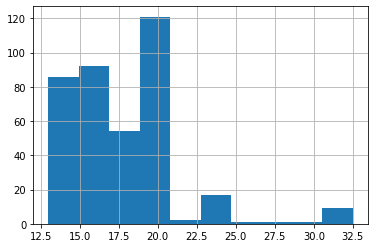

In [21]:
df['Interest_Rate'].hist()
plt.show()

In [22]:
df['Interest_Rate'].mean()

18.001145833333336

In [23]:
Interest_Rate_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['Interest_Rate'] = Interest_Rate_imp.fit_transform(df[['Interest_Rate']])

In [24]:
class VIF (BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.correlated_data = []
        return

    def calc_vif(self, X):  
        vif_data = pd.DataFrame()
        vif_data['feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
        return vif_data

    def remove_correlated_data(self, X):
        self.correlated_data = []
        vif = self.calc_vif(X)
        to_remove = vif['feature'].loc[vif['VIF'] == max(vif['VIF'])]
        X = X.drop(to_remove.values, axis=1)
        self.correlated_data.append(to_remove.values)
        return X

    def fit(self, X, y=None, **kwargs):
        X = pd.DataFrame(X, columns=pipe_vif[:-1].get_feature_names_out())  
        while len(self.calc_vif(X)['feature'].
              loc[self.calc_vif(X)['VIF'] > 10]) > 0:
            X = self.remove_correlated_data(X)
        return self

    def transform(self, X, y=None, **kwargs):
        X = pd.DataFrame(X, columns = pipe_vif[:-1].get_feature_names_out())
        for i in self.correlated_data:
            X = X.drop(i, axis=1)
        return X

    def fit_transform(self, X, y=None, **kwargs):
        self.fit(X)
        return self.transform(X)



In [25]:
class MyTransformer:

    def __init__(self, transformer):
        self.transformer = transformer
    
    def fit(self, X, y=None, **kwargs):
        X = pd.DataFrame(X)
        self.transformer = ColumnTransformer([('transformer', self.transformer, X.keys())],
                                         verbose_feature_names_out=False, remainder='passthrough')
        self.transformer = self.transformer.fit(X)
        return self

    def transform(self, X, y=None, **kwargs):
        return pd.DataFrame(self.transformer.transform(X), 
                        columns=self.transformer.get_feature_names_out())

    def fit_transform(self, X, y=None, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.transformer.get_feature_names_out()

In [26]:
df = df.drop(['Lead_Creation_Date'], axis=1)

In [27]:
X = df.drop(['Disbursed'], axis=1)
y = df['Disbursed']

In [28]:
cols_numerical = X.select_dtypes(include=['int64', 'float64']).columns
 
transformer_numerical = Pipeline(steps = [('Imputer_num', 
                                           MyTransformer(SimpleImputer(missing_values=np.nan, 
                                                         strategy='constant',
                                                         fill_value=0))),
                                           ('Scaler',
                                            MyTransformer(StandardScaler()))])

cols_categorical = X.select_dtypes(include=['object']).columns
 
transformer_categorical = Pipeline(steps = [('Imputer_cat',
                                             MyTransformer(SimpleImputer(missing_values=np.nan,
                                                           strategy='most_frequent'))),
                                             ('Encoder', MyTransformer(OneHotEncoder(drop ='first',
                                                             handle_unknown='ignore', sparse=False)))])

In [29]:
preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)
], verbose_feature_names_out=False)

In [30]:
pipe_vif = Pipeline(steps = [('preprocessor', preprocessor),
                         ('vif', VIF())])
X = pipe_vif.fit_transform(X)

In [31]:
X

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,EMI_Loan_Submitted,age,...,Var1_HCXF,Var1_HCXG,Var1_HCYS,Var1_HVYS,Filled_Form_Y,Device_Type_Web-browser,Var2_C,Var2_E,Var2_F,Var2_G
0,-0.322933,0.078559,1.339224,-0.441472,-1.027973,-0.858881,-1.264198,0.000000,-0.606027,0.841822,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.083492,-0.135557,-0.138405,-0.441472,1.297352,-0.229825,-0.353720,-2.178647,0.379659,-0.135417,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.283026,0.720908,0.846681,-0.441472,-1.027973,0.556494,0.556757,0.000000,-0.606027,0.423005,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.083492,1.577374,1.339224,-0.441472,0.760739,2.034775,1.011996,0.000000,-0.606027,-0.414629,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.954084,0.506792,-0.138405,2.413060,2.012837,0.713758,-0.353720,0.000000,-0.606027,0.004188,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.243119,0.078559,1.339224,-0.441472,1.118481,0.084702,1.011996,0.458026,0.528216,-0.414629,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
996,0.954084,0.506792,0.846681,1.442519,1.655095,0.713758,0.556757,0.000000,-0.606027,-0.554234,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
997,0.155948,1.577374,1.339224,0.962958,1.476224,1.814605,1.011996,0.916578,2.676211,0.841822,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
998,0.315575,-0.349673,1.339224,3.269419,-1.027973,-0.858881,-1.264198,0.000000,-0.606027,0.004188,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
pipe_vif.named_steps.vif.correlated_data

[array(['Var4'], dtype=object)]

In [33]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42) 

In [34]:
y_train.value_counts()

0    791
1      9
Name: Disbursed, dtype: int64

In [35]:
y_train.value_counts()[0] / y_train.value_counts()[1]

87.88888888888889

In [36]:
y_test.value_counts()[0] / y_test.value_counts()[1]

99.0

In [37]:
pipe_model = Pipeline(steps = [('model', None)])

In [38]:
param_grid = [
    
    {
        'model__class_weight' : [{0 : 0.001, 1 : 1}, {0 : 0.01, 1 : 1},
                                 {0 : 0.1, 1 : 1}, 'balanced'],
        'model__n_estimators' : sp_randint(200, 500),
        'model__max_depth' : np.arange(1, 11, 1),
        'model__min_samples_split' : np.arange(2, 10, 1),
        'model__min_samples_leaf' : sp_randint(1, 12),
        'model__ccp_alpha' : [0, 0.001, 0.01, 0.1, 5, 10, 50, 100, 500, 1000, 5000],
        'model': [RandomForestClassifier()]
    },
    {
        'model__class_weight' : [{0 : 0.001, 1 : 1}, {0 : 0.01, 1 : 1},
                                 {0 : 0.1, 1 : 1}, 'balanced'],
        'model__loss' : ['hinge', 'modified_huber', 'perceptron'] ,
        # sprawdzić model__learning_rate()
        'model': [SGDClassifier(max_iter=10000, tol=1e-3)]
    },
    {
        'model__scale_pos_weight' : np.arange(50, 100, 1),
        'model__n_estimators' : sp_randint(10, 100),
        'model__max_depth': np.arange(2, 9),
        'model__learning_rate': np.arange(0.01, 0.3, 0.01),
        'model__colsample_bytree': np.arange(0.1, 1, 0.1),
        'model__gamma': np.arange(0, 20, 2),
        'model': [XGBClassifier()]
    }
]

grid = RandomizedSearchCV(pipe_model, param_grid, n_iter=10, scoring='roc_auc')
grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('model', None)]),
                   param_distributions=[{'model': [RandomForestClassifier()],
                                         'model__ccp_alpha': [0, 0.001, 0.01,
                                                              0.1, 5, 10, 50,
                                                              100, 500, 1000,
                                                              5000],
                                         'model__class_weight': [{0: 0.001,
                                                                  1: 1},
                                                                 {0: 0.01,
                                                                  1: 1},
                                                                 {0: 0.1, 1: 1},
                                                                 'balanced'],
                                         'model__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                         'model__min_samples_leaf': <scipy.stats._dist...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                         'model__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                                         'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E39B7AA200>,
                                         'model__scale_pos_weight': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}],
                   scoring='roc_auc')

In [39]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [128]:
results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ignore_index=True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,...,param_model__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027428,4.461227e-04,0.003192,3.991613e-04,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.7,14,0.14,2,86,...,NaN,"{'model': XGBClassifier(base_score=0.5, booste...",0.899371,0.840764,0.895570,0.920886,0.654088,0.842136,0.097669,1
1,0.010771,3.986836e-04,0.003293,3.996950e-04,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.7,18,0.23,3,15,...,NaN,"{'model': XGBClassifier(base_score=0.5, booste...",0.905660,0.833333,0.901899,0.870253,0.694969,0.841223,0.077626,2
2,0.035499,3.131504e-03,0.003391,4.885193e-04,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.5,2,0.29,6,81,...,NaN,"{'model': XGBClassifier(base_score=0.5, booste...",0.987421,0.749469,0.829114,0.936709,0.603774,0.821297,0.136714,3
3,0.002992,6.975526e-07,0.001995,6.309020e-04,SGDClassifier(max_iter=10000),NaN,NaN,NaN,NaN,NaN,...,hinge,"{'model': SGDClassifier(max_iter=10000), 'mode...",0.949686,0.619958,0.974684,0.740506,0.748428,0.806652,0.135139,4
4,0.028226,3.996233e-04,0.003391,4.884025e-04,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.8,0,0.21,2,87,...,NaN,"{'model': XGBClassifier(base_score=0.5, booste...",0.911950,0.864119,0.911392,0.914557,0.283019,0.777007,0.247710,5
5,0.019648,6.894954e-03,0.003790,7.465441e-04,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.1,4,0.03,7,35,...,NaN,"{'model': XGBClassifier(base_score=0.5, booste...",0.968553,0.647558,0.566456,0.819620,0.654088,0.731255,0.144387,6
6,0.003192,3.989221e-04,0.001994,2.780415e-07,SGDClassifier(max_iter=10000),NaN,NaN,NaN,NaN,NaN,...,hinge,"{'model': SGDClassifier(max_iter=10000), 'mode...",0.553459,0.562633,0.949367,0.857595,0.616352,0.707881,0.163738,7
7,0.002592,4.887762e-04,0.001995,1.784161e-07,SGDClassifier(max_iter=10000),NaN,NaN,NaN,NaN,NaN,...,modified_huber,"{'model': SGDClassifier(max_iter=10000), 'mode...",0.320755,0.709130,1.000000,0.759494,0.534591,0.664794,0.227426,8
8,0.002394,4.889281e-04,0.001995,5.223489e-07,SGDClassifier(max_iter=10000),NaN,NaN,NaN,NaN,NaN,...,perceptron,"{'model': SGDClassifier(max_iter=10000), 'mode...",0.798742,0.602972,0.949367,0.670886,0.257862,0.655966,0.231511,9
9,0.476574,5.989260e-03,0.036599,7.524246e-04,RandomForestClassifier(),NaN,NaN,NaN,7,412,...,NaN,"{'model': RandomForestClassifier(), 'model__cc...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,10


In [41]:
grid.best_params_

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7000000000000001, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=14, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.14, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=86, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 'model__colsample_bytree': 0.7000000000000001,
 'model__gamma': 14,
 'model__learning_rate': 0.14,
 'model__max_depth': 2,
 'model__n_estimators': 86,
 'model__scale_pos_weight': 89}

In [42]:
pipe_model.set_params(**grid.best_params_)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7000000000000001,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=14, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.14,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=2,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=86, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

In [44]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7000000000000001,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=14, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.14, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=2, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=86, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [45]:
roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])
#0.6367772773232835
#0.6629745381009284
#0.6700523945215553
#0.6852192297086129
#0.7369426445719696
#0.7514195648520064
#0.7659560067681895

0.5606060606060607

In [46]:
y_test.sum()

2

In [47]:
pipe_model.predict_proba(X_test)

array([[0.9816447 , 0.0183553 ],
       [0.8755777 , 0.1244223 ],
       [0.9931086 , 0.0068914 ],
       [0.99223703, 0.00776299],
       [0.83936566, 0.16063432],
       [0.9859933 , 0.0140067 ],
       [0.9927911 , 0.00720889],
       [0.99445933, 0.00554068],
       [0.9757843 , 0.02421572],
       [0.9927911 , 0.00720889],
       [0.99470675, 0.00529324],
       [0.99445933, 0.00554068],
       [0.9941928 , 0.00580725],
       [0.9859933 , 0.0140067 ],
       [0.52422434, 0.47577566],
       [0.9937457 , 0.00625429],
       [0.9949756 , 0.00502436],
       [0.9927911 , 0.00720889],
       [0.65600944, 0.3439906 ],
       [0.60863626, 0.39136374],
       [0.4053071 , 0.5946929 ],
       [0.9757843 , 0.02421572],
       [0.9931086 , 0.0068914 ],
       [0.99542534, 0.00457467],
       [0.9937457 , 0.00625429],
       [0.9927911 , 0.00720889],
       [0.9941928 , 0.00580725],
       [0.9892175 , 0.01078248],
       [0.98289233, 0.01710765],
       [0.98560244, 0.01439759],
       [0.

In [48]:
def plot_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    return plt.show()

def get_results(model_name, model, X_test, y_test):
    auc = round(roc_auc_score(y_test, model.predict(X_test)), 3)
    precision = round(precision_score(y_test, model.predict(X_test)), 3)
    accuracy = round(accuracy_score(y_test, model.predict(X_test)), 3)
    print(f'model: {model_name}\n')
    print(f'accuracy_score: {accuracy}')
    print(f'roc_auc_score: {auc}')
    print(f'precision_score: {precision}\n')
    plot_confusion_matrix(y_test=y_test, y_pred=model.predict(X_test))
    return auc

model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7000000000000001, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=14, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.14, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=86, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

accuracy_score: 0.93
roc_auc_score: 0.47
precision_score: 0.0



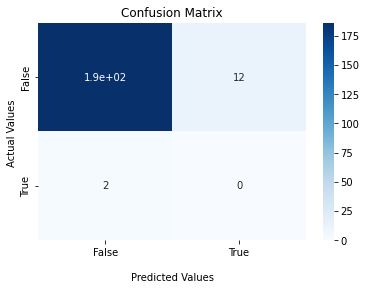

0.47

In [49]:
get_results(model_name=grid.best_params_['model'], model=pipe_model, X_test=X_test, y_test=y_test)

# Prediction of test data

In [50]:
#raise SystemExit()
test

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
0,ID000026A10,Male,Dehradun,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,100000.0,3.0,20.0,1000.0,2649.39,N,Web-browser,B,S122,3
1,ID000054C40,Male,Mumbai,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,690000.0,5.0,24.0,13800.0,19849.90,Y,Mobile,C,S133,5
2,ID000066O10,Female,Jaipur,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1
3,ID000110G00,Female,Chennai,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,NaN,NaN,NaN,NaN,NaN,N,Mobile,C,S133,1
4,ID000113J30,Male,Chennai,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,100000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37712,ID124809J40,Female,Ponda,40000,28-Dec-71,31-Jul-15,1000000.0,4.0,10000.0,GOVT EMPLOYEE,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,3
37713,ID124817R20,Male,Chandigarh,20500,09-Feb-84,31-Jul-15,0.0,0.0,0.0,MAX SUPER SPECIALITY HOSPITAL MOHALI,...,330000.0,4.0,31.5,6600.0,12171.60,Y,Mobile,G,S122,5
37714,ID124820U00,Male,Meerut,25000,18-Dec-69,31-Jul-15,0.0,0.0,0.0,C.I.S.F,...,390000.0,4.0,NaN,NaN,NaN,N,Mobile,G,S122,3
37715,ID124822W20,Female,Kolkata,130000,01-Jan-72,31-Jul-15,600000.0,0.0,67000.0,TATA STEEL LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1


In [51]:
train.keys()

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed'],
      dtype='object')

In [52]:
test.keys()

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4'],
      dtype='object')

In [53]:
for key in test.keys():
    if key not in train.keys():
        test = test.drop([key], axis=1)

In [54]:
test.keys()

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4'],
      dtype='object')

In [55]:
cities = make_cities_df(test['City'])
count = calc_number_of_occurrences(test['City'], drop=True)
cities = pd.concat([cities, count], axis=1)
cities = create_categories(cities, Q1_cities, Q2_cities)

size = {}
for i, n in enumerate(cities['city_name']):
    size[n] = cities['city_size'][i]

test['City'] = test['City'].map(size).fillna('medium')

In [56]:
years = []
for year in test['Lead_Creation_Date']:
    years.append(pd.Timestamp(year).year)

test['age'] = date_to_years(test['DOB'], years)
test = test.drop(['DOB'], axis=1)

In [57]:
count = calc_number_of_occurrences(test['Salary_Account'])
count = create_categories_salary(count, Q1_Salary_Account, Q2_Salary_Account)
size = {}
for i, n in enumerate(count['name']):
    size[n] = count['category'][i]
size
test['Salary_Account'] = test['Salary_Account'].map(size).fillna('big')

In [58]:
test['Loan_Tenure_Applied'].loc[test['Loan_Tenure_Applied'].isnull()]\
 = test['Loan_Tenure_Submitted'].loc[test['Loan_Tenure_Applied'].isnull()]

test['Loan_Amount_Applied'].loc[test['Loan_Amount_Applied'].isnull()]\
 = test['Loan_Amount_Submitted'].loc[test['Loan_Amount_Submitted'].isnull()]

In [59]:
test = test.drop(['Lead_Creation_Date'], axis=1)
X_test = test.drop(['ID'], axis=1)

In [60]:
X_test = test.drop(['ID'], axis=1)

In [62]:
X_test = pipe_vif.transform(X_test)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37717 entries, 0 to 37716
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly_Income           37717 non-null  float64
 1   Loan_Amount_Applied      37717 non-null  float64
 2   Loan_Tenure_Applied      37717 non-null  float64
 3   Existing_EMI             37717 non-null  float64
 4   Var5                     37717 non-null  float64
 5   Loan_Amount_Submitted    37717 non-null  float64
 6   Loan_Tenure_Submitted    37717 non-null  float64
 7   Interest_Rate            37717 non-null  float64
 8   EMI_Loan_Submitted       37717 non-null  float64
 9   age                      37717 non-null  float64
 10  Gender_Male              37717 non-null  float64
 11  Salary_Account_medium    37717 non-null  float64
 12  Salary_Account_small     37717 non-null  float64
 13  Mobile_Verified_Y        37717 non-null  float64
 14  Var1_HAXA             

D:\anaconda\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [63]:
for key in X_test.keys():
    if key not in X.keys():
        X_test = X_test.drop([key], axis=1)
for key in X.keys():
    if key not in X_test.keys():
        X_test[key] = 0

In [64]:
results = pd.DataFrame({'LoggedIn' : test['ID'], 'Disbursed' : pipe_model.predict(X_test)})
results

,LoggedIn,Disbursed
0,ID000026A10,0
1,ID000054C40,0
2,ID000066O10,0
3,ID000110G00,0
4,ID000113J30,0
...,...,...
37712,ID124809J40,0
37713,ID124817R20,0
37714,ID124820U00,0
37715,ID124822W20,0


In [67]:
results['Disbursed'].sum()

803